In [76]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from collections import Counter

from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import (
train_test_split, cross_validate, GridSearchCV, KFold, cross_val_score
)

from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x : "%.3f" % x)
pd.set_option('display.width', 500)
#Custom options while printing the dataframes

custom_palette = [
    "#0B3C5D",  # deep clinical blue
    "#328CC1",  # medium blue
    "#D9B310",  # muted gold for contrast
    "#1D2731" 
]
sns.set_palette(sns.color_palette(custom_palette))

# Basic Overview of the data

In [20]:
df = pd.read_csv("/kaggle/input/health-insurance-dataset/medical_insurance.csv")

In [21]:
df.shape, df.columns

((1338, 8),
 Index(['age', 'gender', 'bmi', 'children', 'discount_eligibility', 'region', 'expenses', 'premium'], dtype='object'))

In [22]:
df.isna().sum()

age                     0
gender                  0
bmi                     0
children                0
discount_eligibility    0
region                  0
expenses                0
premium                 0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1338 non-null   int64  
 1   gender                1338 non-null   object 
 2   bmi                   1338 non-null   float64
 3   children              1338 non-null   int64  
 4   discount_eligibility  1338 non-null   object 
 5   region                1338 non-null   object 
 6   expenses              1338 non-null   float64
 7   premium               1338 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 83.8+ KB


In [24]:
x = df[df.duplicated()]
x, len(x), type(x)

(     age gender    bmi  children discount_eligibility     region  expenses  premium
 581   19   male 30.600         0                   no  northwest  1639.560   16.396,
 1,
 pandas.core.frame.DataFrame)

In [25]:
df = df.drop_duplicates()
df = df.reset_index(drop = True)
df.shape #One row was removed- the duplicated one

(1337, 8)

In [26]:
df.apply(lambda x: len(x.unique())) # Alternatively df.nunique()

age                       47
gender                     2
bmi                      275
children                   6
discount_eligibility       2
region                     4
expenses                1337
premium                 1337
dtype: int64

In [27]:
profile = ProfileReport(df, 
                       title = 'Dataset Report',
                       minimal = True,
                       progress_bar = False,
                       samples = None,
                       correlations = None,
                       interactions = None,
                       explorative = True,
                       notebook = {'iframe':{'height': '600px'}},
                       html = {'style': {'primary_color': '#C44536'}},
                       missing_diagrams = {'heatmap': False, "dendogram": False})

profile.to_notebook_iframe()

100%|██████████| 8/8 [00:00<00:00, 197.36it/s]


# Basic Visualizations

In [28]:
hm = df.drop(columns = ['discount_eligibility', 'gender', 'region'])
custom_colors = ["#B7D5D4", "#77878B", "#488286", "#305252"]
custom_cmap = LinearSegmentedColormap.from_list("custom_bone", custom_colors)

In [29]:
styled_corr = hm.corr(numeric_only = True).T.style.background_gradient(cmap = custom_cmap, axis = 1)
styled_corr

,age,bmi,children,expenses,premium
age,1.000000,0.109414,0.041536,0.298308,0.529971
bmi,0.109414,1.000000,0.012641,0.198637,0.177928
children,0.041536,0.012641,1.000000,0.067389,0.041868
expenses,0.298308,0.198637,0.067389,1.000000,0.853921
premium,0.529971,0.177928,0.041868,0.853921,1.000000


# Preprocessing Data for Modelling

In [32]:
# Removing outliers by creating a mask
# All values outside the range of Q1 - 1.5*IQR and Q3 + 1.5*IQR are considered outliers
for col in hm.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[col] < (Q1 - 1.5 * IQR)) & (df[col] > (Q3 + 1.5 * IQR))
    df.drop(index = df[mask].index, inplace = True)
    print(f"{col} has {len(df[mask])} non- outliers values")

age has 0 non- outliers values
bmi has 0 non- outliers values
children has 0 non- outliers values
expenses has 0 non- outliers values
premium has 0 non- outliers values


In [33]:
df.shape

(1337, 8)

In [37]:
# Applying one hot encoding
gender_dummies = pd.get_dummies(df['gender'], dtype = int, drop_first = True)
discount_eligibility_dummies = pd.get_dummies(df['discount_eligibility'], dtype = int, drop_first = True)
region_dummies = pd.get_dummies(df['region'], dtype = int, drop_first = True)

df = pd.concat([df.iloc[:, :-1], region_dummies, df.iloc[:, -1]], axis = 1)
df['gender'] = gender_dummies
df['discount_eligibility'] = discount_eligibility_dummies


In [38]:
df.head()

,age,gender,bmi,children,discount_eligibility,region,expenses,northwest,southeast,southwest,premium
0,19,0,27.900,0,1,southwest,16884.920,0,0,1,168.849
1,18,1,33.800,1,0,southeast,1725.550,0,1,0,17.256
2,28,1,33.000,3,0,southeast,4449.460,0,1,0,44.495
3,33,1,22.700,0,0,northwest,21984.470,1,0,0,439.689
4,32,1,28.900,0,0,northwest,3866.860,1,0,0,77.337


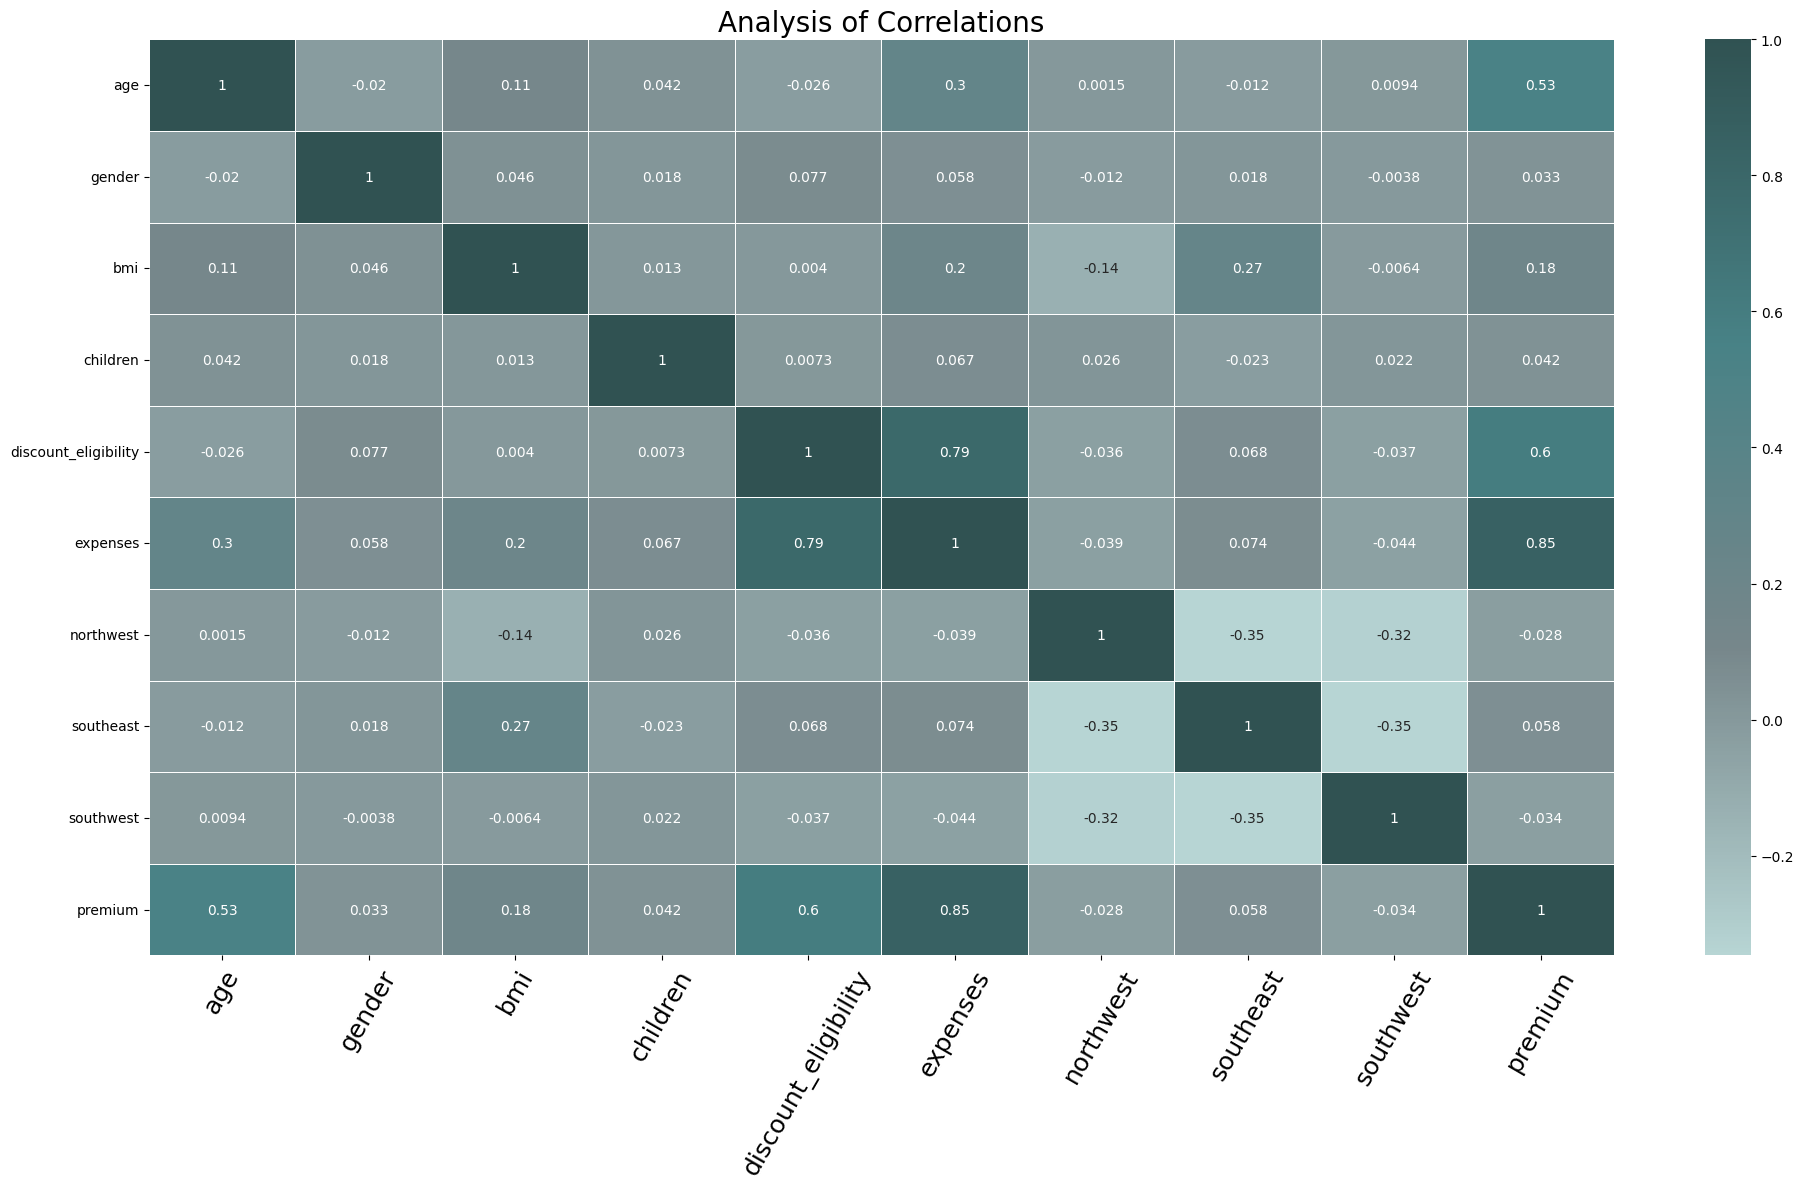

In [43]:
plt.figure(figsize = (20, 12))
sns.heatmap(
    df.corr(numeric_only = True),
    cmap = custom_cmap,
    annot = True,
    linewidths = 0.6,
)

plt.xticks(rotation = 60, size = 18)
plt.yticks(size = 10)
plt.title('Analysis of Correlations', size = 20)
plt.tight_layout()
plt.show()

# Modelling

In [55]:
features1 = [x for x in df.columns[:6]]
features2 = [x for x in df.columns[7:]]
features = features1 + features2
target = 'expenses'

In [73]:
X = df[features].drop(columns = ['region'], axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

First, we will create an entire structure of models, their parameters and metrics

In [78]:
def adjusted_r2(r2, n_samples, n_features):
    return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

In [79]:
model_candidates = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Bayesian Ridge': BayesianRidge(),
    'Huber Regressor': HuberRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(verbosity=0), 
    'LightGBM': LGBMRegressor(verbose=-1),  
    'CatBoost': CatBoostRegressor(verbose=0)
}

param_grids = {
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso Regression': {'alpha': [0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]},
    'Bayesian Ridge': {
        'alpha_1': [1e-6, 1e-5, 1e-4], 'alpha_2': [1e-6, 1e-5, 1e-4],
        'lambda_1': [1e-6, 1e-5, 1e-4], 'lambda_2': [1e-6, 1e-5, 1e-4]
    },
    'Huber Regressor': {'alpha': [0.0001, 0.001, 0.01]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30]},
    'Random Forest': {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']},
    'Support Vector Regressor': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1.0, 10.0], 'epsilon': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2]},
    'LightGBM': {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2]},
    'CatBoost': {'iterations': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2]}
}

results = {
    'Model': [],
    'MSE_Train': [],
    'R2_Train': [],
    'Adj_R2_Train': [],
    'MAE_Train': [],
    'MSE_Test': [],
    'R2_Test': [],
    'Adj_R2_Test': [],
    'MAE_Test': [],
    'y_test_true': [],
    'y_test_pred': [],
    'y_train_true': [],
    'y_train_pred': []
}

In [80]:
for name, model in model_candidates.items():
    print(f"Training model- {name}: ")
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], scoring = 'neg_mean_squared_error', cv = 5, n_jobs = 1, verbose = 1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)
        
    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    adj_r2_train = adjusted_r2(r2_train, len(y_train), X_train_scaled.shape[1])
    mae_train = mean_absolute_error(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adj_r2_test = adjusted_r2(r2_test, len(y_test), X_test_scaled.shape[1])
    mae_test = mean_absolute_error(y_test, y_test_pred)

    results['Model'].append(name)
    results['MSE_Train'].append(mse_train)
    results['R2_Train'].append(r2_train)
    results['Adj_R2_Train'].append(adj_r2_train)
    results['MAE_Train'].append(mae_train)
    results['MSE_Test'].append(mse_test)
    results['R2_Test'].append(r2_test)
    results['Adj_R2_Test'].append(adj_r2_test)
    results['MAE_Test'].append(mae_test)
    results['y_test_true'].append(y_test)
    results['y_test_pred'].append(y_test_pred)
    results['y_train_true'].append(y_train)
    results['y_train_pred'].append(y_train_pred)
    
results_df = pd.DataFrame(results).sort_values(by = 'R2_Test', ascending = False).reset_index(drop = True)    


Training model- Ridge Regression: 
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training model- Lasso Regression: 
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training model- ElasticNet: 
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training model- Bayesian Ridge: 
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model- Huber Regressor: 
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training model- Decision Tree: 
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training model- Random Forest: 
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training model- Gradient Boosting: 
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training model- AdaBoost: 
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training model- K-Nearest Neighbors: 
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training model- Support Vector Regressor: 
Fitting 5 folds for eac

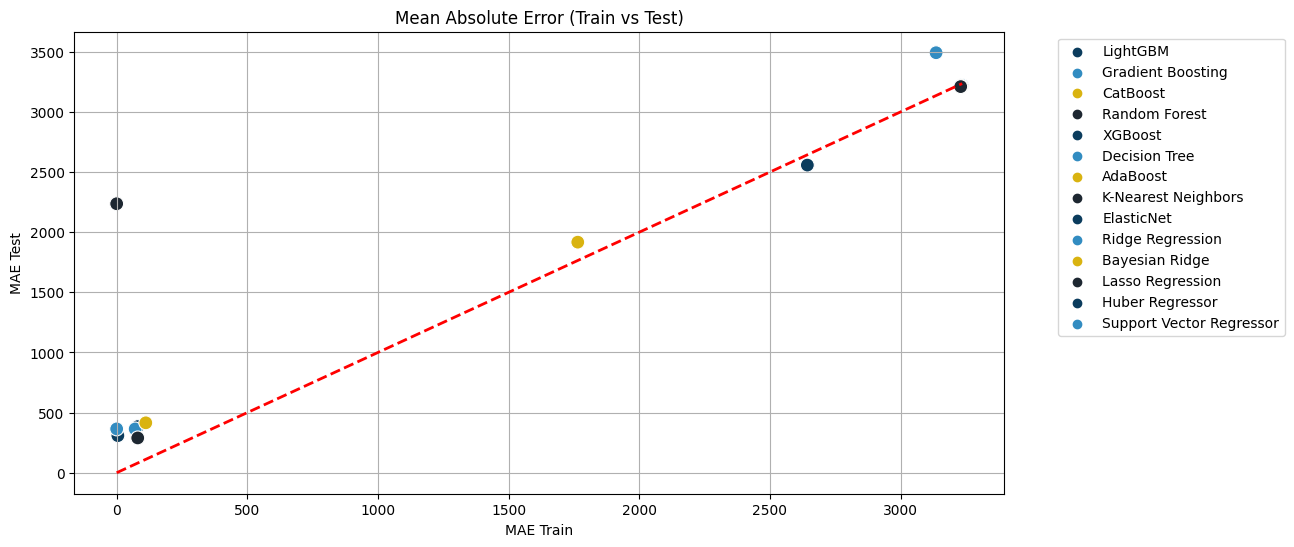

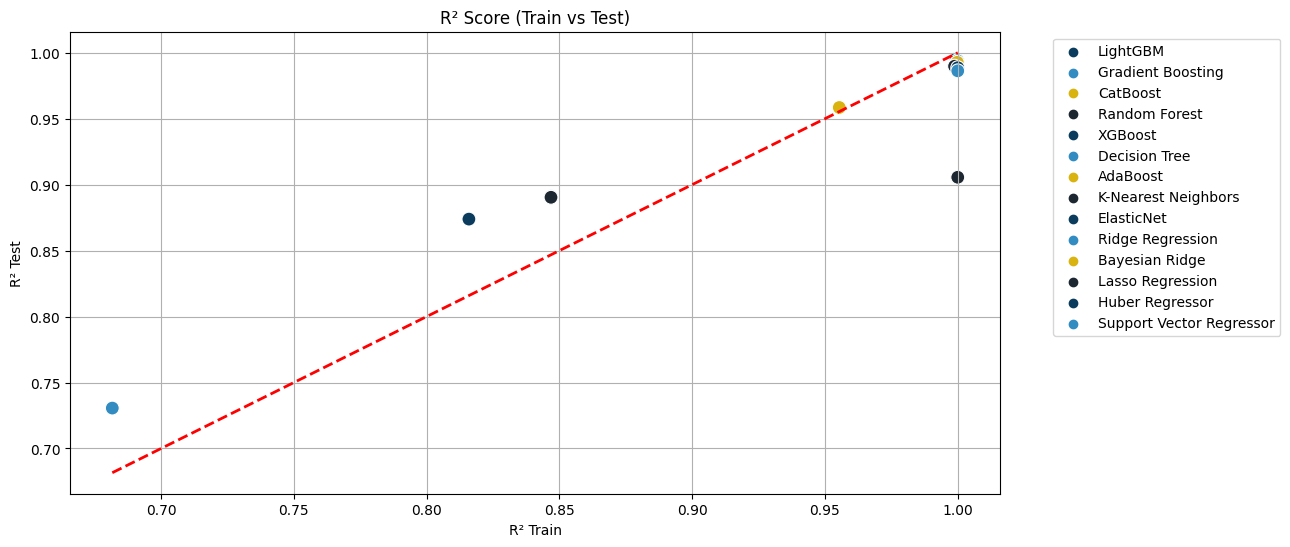

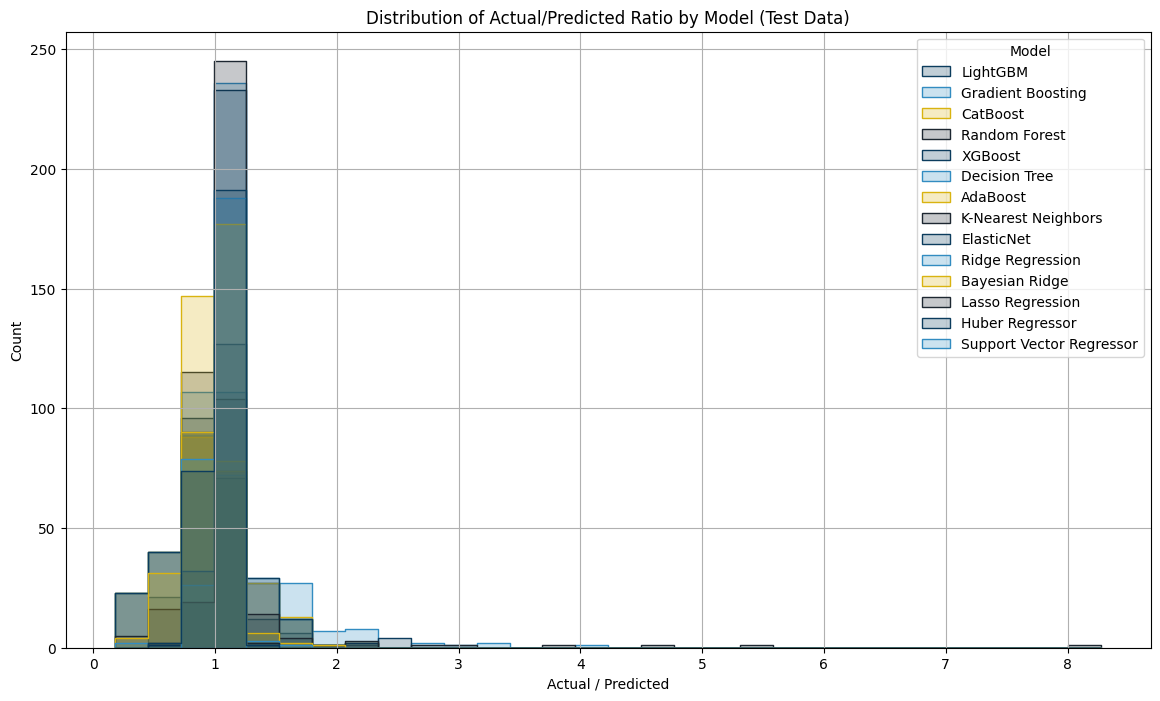

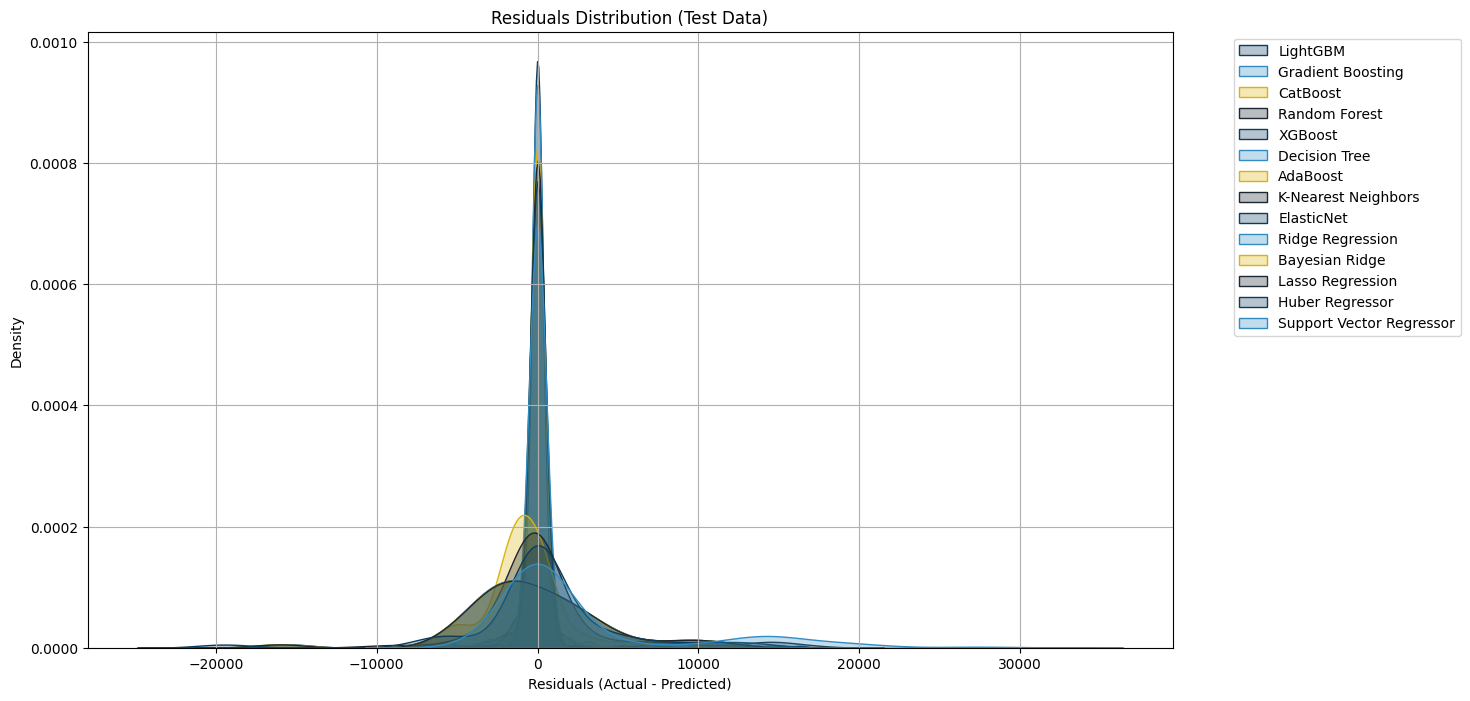

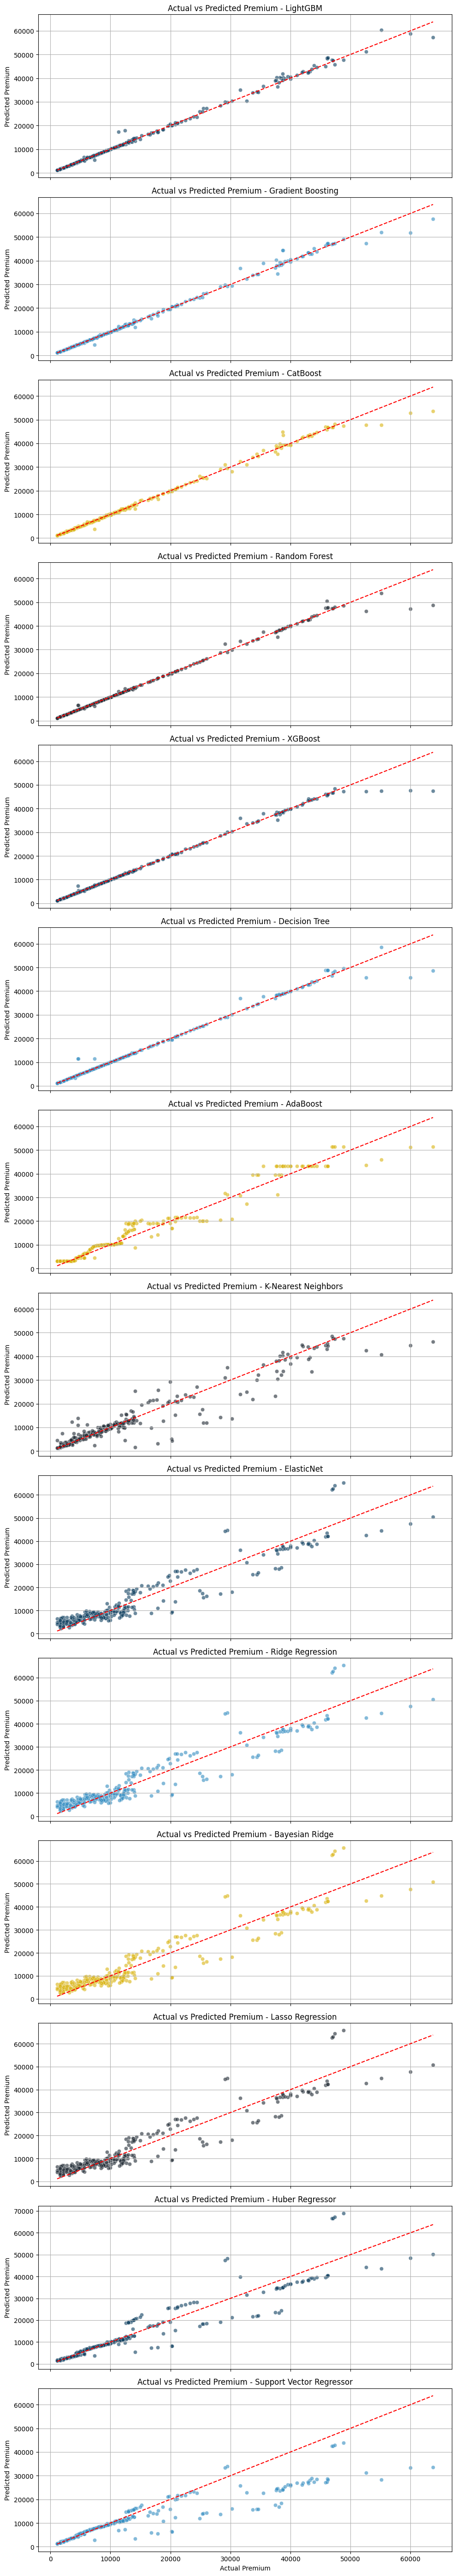

,Model,MSE_Train,MAE_Train,R2_Train,Adj_R2_Train,MSE_Test,MAE_Test,R2_Test,Adj_R2_Test
0,LightGBM,78008.49,80.75,0.999,0.999,892656.19,383.54,0.995,0.995
1,Gradient Boosting,10875.68,70.71,1.000,1.000,1116168.50,363.81,0.994,0.994
2,CatBoost,24366.23,111.45,1.000,1.000,1340036.84,414.83,0.993,0.992
3,Random Forest,163951.58,80.56,0.999,0.999,1878994.49,289.19,0.990,0.989
4,XGBoost,40.60,4.58,1.000,1.000,2085976.95,308.34,0.989,0.988
5,Decision Tree,0.00,0.00,1.000,1.000,2524910.00,364.31,0.986,0.986
6,AdaBoost,6107929.89,1764.54,0.955,0.955,7629251.70,1916.95,0.958,0.957
7,K-Nearest Neighbors,0.00,0.00,1.000,1.000,17347465.86,2236.28,0.906,0.902
8,ElasticNet,20975740.02,3235.40,0.847,0.845,20063552.17,3219.84,0.891,0.887
9,Ridge Regression,20974866.68,3235.15,0.847,0.846,20068583.71,3219.27,0.891,0.887


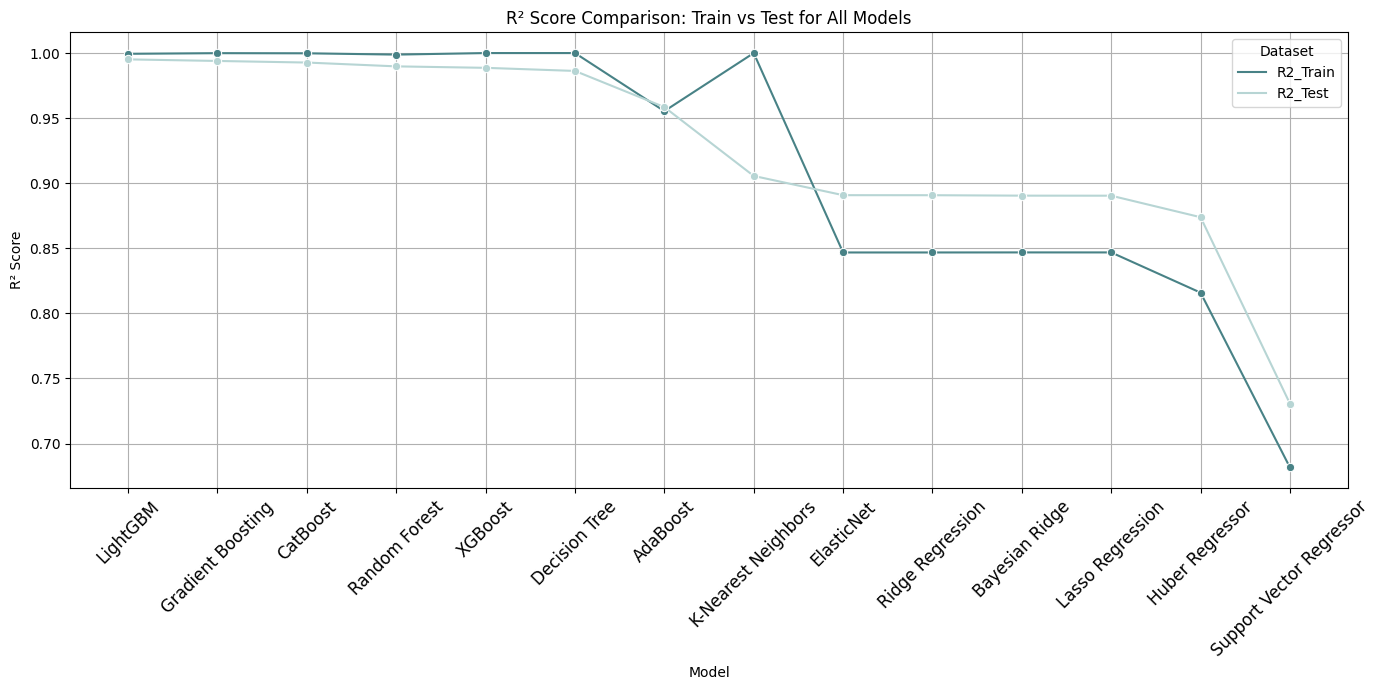

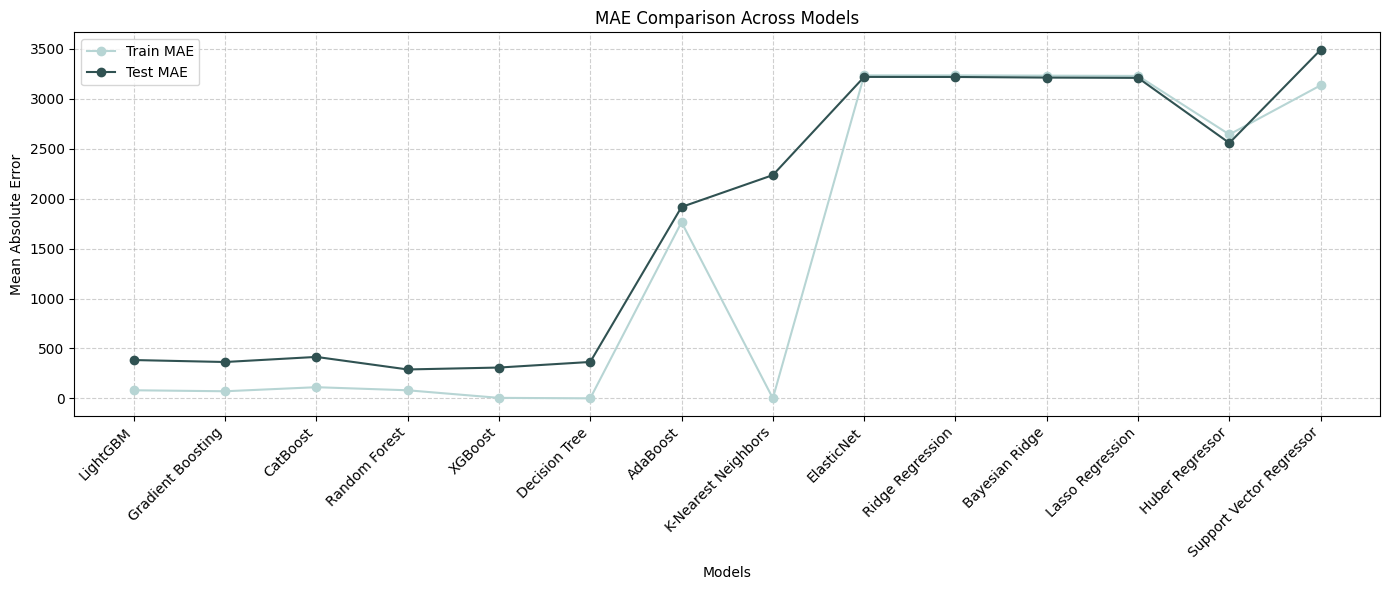

In [81]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='MAE_Train', y='MAE_Test', data=results_df, hue='Model', palette=custom_palette, s=100)
plt.plot([results_df['MAE_Train'].min(), results_df['MAE_Train'].max()],
         [results_df['MAE_Train'].min(), results_df['MAE_Train'].max()],
         'r--', lw=2)
plt.title('Mean Absolute Error (Train vs Test)')
plt.xlabel('MAE Train')
plt.ylabel('MAE Test')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x='R2_Train', y='R2_Test', data=results_df, hue='Model', palette=custom_palette, s=100)
plt.plot([results_df['R2_Train'].min(), results_df['R2_Train'].max()],
         [results_df['R2_Train'].min(), results_df['R2_Train'].max()],
         'r--', lw=2)
plt.title('R² Score (Train vs Test)')
plt.xlabel('R² Train')
plt.ylabel('R² Test')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
ratios = []
models_expanded = []
for i, row in results_df.iterrows():
    ratio = row['y_test_true'] / (row['y_test_pred'] + 1e-8)  # prevent division by zero
    ratios.extend(ratio)
    models_expanded.extend([row['Model']]*len(ratio))

df_ratio = pd.DataFrame({'Ratio': ratios, 'Model': models_expanded})
sns.histplot(data=df_ratio, x='Ratio', hue='Model', element='step', stat='count', palette=custom_palette, bins=30)
plt.title('Distribution of Actual/Predicted Ratio by Model (Test Data)')
plt.xlabel('Actual / Predicted')
plt.ylabel('Count')
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
for i, row in results_df.iterrows():
    residuals = row['y_test_true'] - row['y_test_pred']
    sns.kdeplot(residuals, label=row['Model'], fill=True, alpha=0.3)
plt.title('Residuals Distribution (Test Data)')
plt.xlabel('Residuals (Actual - Predicted)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

fig, axs = plt.subplots(len(results_df), 1, figsize=(10, len(results_df)*4), sharex=True)
if len(results_df) == 1:
    axs = [axs]

for i, row in results_df.iterrows():
    sns.scatterplot(x=row['y_test_true'], y=row['y_test_pred'], ax=axs[i], color=custom_palette[i % len(custom_palette)], alpha=0.6)
    axs[i].plot([row['y_test_true'].min(), row['y_test_true'].max()], [row['y_test_true'].min(), row['y_test_true'].max()], 'r--')
    axs[i].set_title(f'Actual vs Predicted Premium - {row["Model"]}')
    axs[i].set_xlabel('Actual Premium')
    axs[i].set_ylabel('Predicted Premium')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Color map for table styling
custom_cmap = LinearSegmentedColormap.from_list("custom", custom_palette)

# Styled summary table
styled_results = results_df[['Model', 'MSE_Train', 'MAE_Train', 'R2_Train', 'Adj_R2_Train',
                             'MSE_Test', 'MAE_Test', 'R2_Test', 'Adj_R2_Test']].style\
    .background_gradient(cmap=custom_cmap, axis=1)\
    .format({
        'MSE_Train': "{:.2f}",
        'MAE_Train': "{:.2f}",
        'R2_Train': "{:.3f}",
        'Adj_R2_Train': "{:.3f}",
        'MSE_Test': "{:.2f}",
        'MAE_Test': "{:.2f}",
        'R2_Test': "{:.3f}",
        'Adj_R2_Test': "{:.3f}",
    })\
    .set_caption("Comprehensive Regression Models Performance Summary - Target: Premium")

display(styled_results)

# Additional line plot for train vs test R2 scores
plt.figure(figsize=(14, 7))
df_long = pd.melt(results_df[['Model', 'R2_Train', 'R2_Test']], id_vars='Model', 
                  value_vars=['R2_Train', 'R2_Test'],
                  var_name='Dataset', value_name='R2_Score')

palette = ['#488286', '#B7D5D4'] 

sns.lineplot(data=df_long, x='Model', y='R2_Score', hue='Dataset', marker='o', palette=palette)
plt.xticks(rotation=45, fontsize=12)
plt.title('R² Score Comparison: Train vs Test for All Models')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.legend(title='Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional line plot for MAE comparison
plt.figure(figsize=(14, 6))
plt.plot(results_df['Model'], results_df['MAE_Train'], marker='o', label='Train MAE', color='#B7D5D4')
plt.plot(results_df['Model'], results_df['MAE_Test'], marker='o', label='Test MAE', color='#305252')
plt.xticks(rotation=45, ha='right')
plt.title('MAE Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()